In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Extraction

In [6]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA') 

# Actions that we try to detect
#actions = np.array(['hello','iloveyou','thanks','google','house','jogging','book','internet'])
actions = np.array(['drink','house','drive','hello','iloveyou','thanks','google','internet','jogging','book'])
#actions = np.array(['hello','iloveyou','thanks','google','internet','pizza','jogging','book'])
#actions = np.array(['hello','book','computer','drink','iloveyou','thanks','before', 'chair', 'go']) ,'before', 'chair', 'go','clothes',''google','internet','pizza','televison','twitter',
 #'clothes','who', 'candy', 'cousin'
# Thirty videos worth of data
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30



In [ ]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# collect

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (90,90), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (90,90), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map = {label:num for num, label in enumerate(actions)}

In [9]:
label_map

{'drink': 0,
 'house': 1,
 'drive': 2,
 'hello': 3,
 'iloveyou': 4,
 'thanks': 5,
 'google': 6,
 'internet': 7,
 'jogging': 8,
 'book': 9}

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
np.array(sequences).shape

(400, 30, 1662)

In [12]:
np.array(labels).shape

(400,)

In [13]:
X = np.array(sequences)

In [14]:
y = to_categorical(labels).astype(int)

In [ ]:
X[1]

In [ ]:
y[1]

In [15]:
# Perform the stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
X_train.shape

(320, 30, 1662)

In [17]:
y_test.shape

(80, 10)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
""" log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir) """

In [26]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))  

In [25]:
del model

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 596906 (2.28 MB)
Trainable params: 59690

In [28]:
res = [.7, 0.2, 0.2]

In [29]:
actions[np.argmax(res)]

'drink'

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
y_test

In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint('LSTM_KNN_DTW_BEST_10words_test3.h5', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=300, callbacks=[model_checkpoint])


Epoch 1/300
8/8 [==============================] - 5s 142ms/step - loss: 2.6245 - categorical_accuracy: 0.1172 - val_loss: 2.2837 - val_categorical_accuracy: 0.2031
Epoch 2/300
8/8 [==============================] - 1s 129ms/step - loss: 2.2892 - categorical_accuracy: 0.1797 - val_loss: 2.2351 - val_categorical_accuracy: 0.2812
Epoch 3/300
8/8 [==============================] - 1s 94ms/step - loss: 2.2018 - categorical_accuracy: 0.2227 - val_loss: 1.9080 - val_categorical_accuracy: 0.3906
Epoch 4/300
8/8 [==============================] - 0s 63ms/step - loss: 2.1296 - categorical_accuracy: 0.3008 - val_loss: 2.0694 - val_categorical_accuracy: 0.2656
Epoch 5/300
8/8 [==============================] - 1s 64ms/step - loss: 1.9518 - categorical_accuracy: 0.3516 - val_loss: 2.0004 - val_categorical_accuracy: 0.2812
Epoch 6/300
8/8 [==============================] - 1s 101ms/step - loss: 1.7354 - categorical_accuracy: 0.3125 - val_loss: 1.6739 - val_categorical_accuracy: 0.3281
Epoch 7/300
8

In [ ]:
X_test, y_test

In [32]:
model.save('action10_best_95.h5')

In [33]:
model.load_weights('action10_best_95.h5')

In [34]:
res = model.predict(X_test)

3/3 [==============================] - 1s 25ms/step


In [35]:
from tensorflow.keras.models import load_model
import tensorflow as tf

In [36]:
model_5 = load_model('LSTM_KNN_DTW_BEST_10words_test3.h5')

In [ ]:
model = tf.keras.models.load_model("LSTM_try_6_with_more_test_best_model.h5")

In [37]:
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 596906 (2.28 MB)
Trainable params: 59690

In [43]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, confusion_matrix

In [45]:
yhat = model_5.predict(X_test)

3/3 [==============================] - 1s 19ms/step


In [46]:
actions[np.argmax(res[2])]


'drink'

In [47]:
actions[np.argmax(y_test[2])]

'drink'

In [48]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
ytrue

In [ ]:
yhat

In [49]:
# Precision
precision = precision_score(ytrue, yhat, average='macro')  # or 'binary' if you have binary classification

# Recall
recall = recall_score(ytrue, yhat, average='macro')  # or 'binary' if you have binary classification

# F1 Score
f1 = f1_score(ytrue, yhat, average='macro')  # or 'binary' if you have binary classification

#accuracy score
accuracy = accuracy_score(ytrue, yhat)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.9149567099567101
Recall: 0.8807142857142857
F1 Score: 0.8898852202971197
Accuracy: 0.9


In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

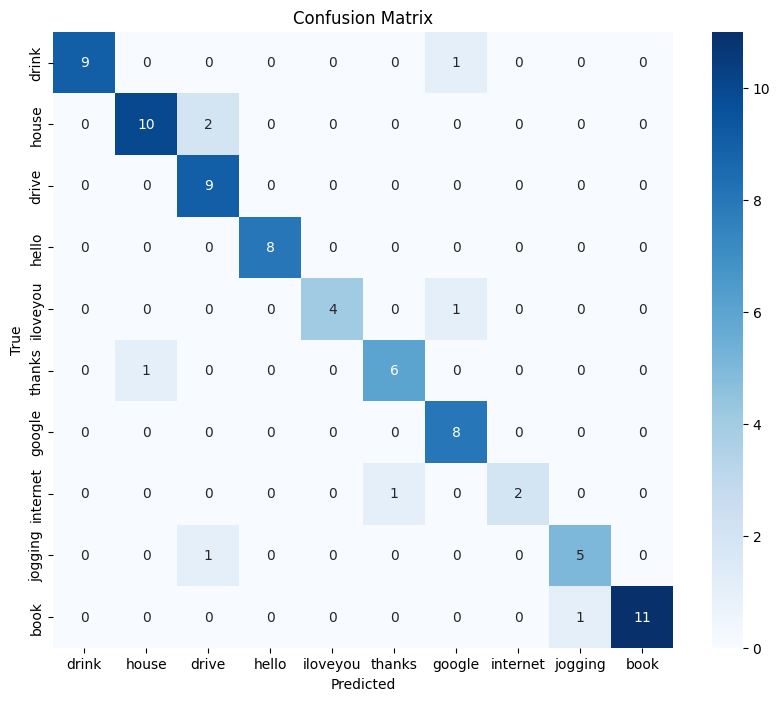

In [52]:
cm = confusion_matrix(ytrue, yhat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

class_counts = np.bincount(y_train)  # Assuming y_train contains the class labels
plt.bar(range(len(class_counts)), class_counts, tick_label=actions)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [ ]:
model.summary()

In [ ]:
model_5 = load_model('action2.h5')

In [ ]:
model_evaluation_history = model_5.evaluate(X_test, y_test)


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  
  epochs = range(len(metric_value_1))
  
  #plot the graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  plt.title(str(plot_name))
  
  plt.legend()

In [ ]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Validation Loss')

In [ ]:
plot_metric(history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Validation Accuracy')

# add noise to keypoints

In [ ]:

def add_noise(X, mean=0, std_dev=0.001):
    noise = np.random.normal(mean, std_dev, X.shape)
    return X + noise

In [ ]:
# Adding noise to X_test
X_test_noisy = add_noise(X_test, mean=1, std_dev=0)

# Making predictions with the noisy X_test
yhat_noisy_probs = model_5.predict(X_test_noisy)

# If the model outputs probabilities, convert them to class labels
# Assuming a multi-class classification problem
yhat_noisy = np.argmax(yhat_noisy_probs, axis=1)

# Ensure y_test is in the same format
y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# Calculate precision and recall
precision = precision_score(y_test_labels, yhat_noisy, average='macro')
recall = recall_score(y_test_labels, yhat_noisy, average='macro')
# F1 Score
f1 = f1_score(ytrue, yhat_noisy, average='macro')  # or 'binary' if you have binary classification

#accuracy score
accuracy = accuracy_score(ytrue, yhat_noisy)


print(f'Precision with noisy data: {precision}')
print(f'Recall with noisy data: {recall}')
print("F1 Score:", f1)
print("Accuracy:", accuracy)


In [ ]:
yhat_noisy = model_5.predict(X_test_noisy)

In [ ]:
# Precision
precision = precision_score(ytrue, yhat_noisy, average='macro')  # or 'binary' if you have binary classification

# Recall
recall = recall_score(ytrue, yhat_noisy, average='macro')  # or 'binary' if you have binary classification

# F1 Score
f1 = f1_score(ytrue, yhat_noisy, average='macro')  # or 'binary' if you have binary classification

#accuracy score
accuracy = accuracy_score(ytrue, yhat_noisy)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

In [ ]:
precision = precision_score(y_test, yhat_noisy, average='binary')

-------------------------

In [ ]:
conf_matrix = confusion_matrix(ytrue, yhat)

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Select the confusion matrix for the first class (index 0)
plt.figure(figsize=(10, 7))  # Set the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)  # 'fmt' is the string format for numeric value
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Optional: Adjust the labels if you have specific class names
class_labels = ["hello","thanks","iloveyou","yes","no"]  # Adjust according to your data
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)

plt.show()

In [ ]:
#compare

In [ ]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (245, 16, 117), (117, 16, 245), (50, 50, 50),(16, 117, 245), (245, 16, 117), (117, 16, 245), (50, 50, 50)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            current_action = actions[np.argmax(res)] if res[np.argmax(res)] > threshold else ""

        # 3. Viz logic
        if len(predictions) > 10 and np.unique(predictions[-10:])[0] == np.argmax(res): 
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

        if len(sentence) > 5: 
            sentence = sentence[-5:]

        # Viz probabilities
        if len(sequence) == 30:
            image = prob_viz(res, actions, image, colors)

        # Create a white image for text display
        text_image = np.ones((frame.shape[0], 400, 3), dtype=np.uint8) * 255
        cv2.putText(text_image, current_action, (10, frame.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 3, cv2.LINE_AA)

        # Concatenate the image and text image
        combined_image = np.hstack((image, text_image))
        
        # Show to screen
        cv2.imshow('OpenCV Feed', combined_image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

-------------------------------

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_high_accuracy = load_model('action.h5')
model_low_accuracy = load_model('test2.h5')

In [ ]:
print("ACTION",model_high_accuracy.summary())


In [ ]:
print("test",model_low_accuracy.summary())

In [ ]:
# Assuming models were compiled before saving
optimizer_high = model_high_accuracy.optimizer.get_config()
optimizer_low = model_low_accuracy.optimizer.get_config()

print("High Accuracy Model Optimizer:", optimizer_high)
print("Low Accuracy Model Optimizer:", optimizer_low)

In [ ]:
import numpy as np

# Load your test dataset

# Evaluate the models
score_high = model_high_accuracy.evaluate(X_test, y_test, verbose=0)
score_low = model_low_accuracy.evaluate(X_test, y_test, verbose=0)

print("High Accuracy Model Test Loss:", score_high[0])
print("High Accuracy Model Test Accuracy:", score_high[1])

print("Low Accuracy Model Test Loss:", score_low[0])
print("Low Accuracy Model Test Accuracy:", score_low[1])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the outputs
y_pred_high = np.argmax(model_high_accuracy.predict(X_test), axis=-1)
y_pred_low = np.argmax(model_low_accuracy.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Confusion Matrix for High Accuracy Model
cm_high = confusion_matrix(y_true, y_pred_high)
ConfusionMatrixDisplay(cm_high).plot()
plt.title('High Accuracy Model')
plt.show()

# Confusion Matrix for Low Accuracy Model
cm_low = confusion_matrix(y_true, y_pred_low)
ConfusionMatrixDisplay(cm_low).plot()
plt.title('Low Accuracy Model')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming the layers have the same names and order
for layer_high, layer_low in zip(model_high_accuracy.layers, model_low_accuracy.layers):
    if len(layer_high.get_weights()) > 0:  # If the layer has weights
        weights_high = layer_high.get_weights()[0]
        weights_low = layer_low.get_weights()[0]

        plt.hist(weights_high.flatten(), bins=50, alpha=0.5, label='High Accuracy')
        plt.hist(weights_low.flatten(), bins=50, alpha=0.5, label='Low Accuracy')
        plt.title(f'Weight Distribution in Layer {layer_high.name}')
        plt.legend()
        plt.show()